In [900]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64

from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG


from functions.utils.system import *
from functions.utils.func import *

import warnings

warnings.filterwarnings('ignore')

# Functions

In [901]:
#Reads in all the results in the "modelName" folder
def read_result(model_name, result_name):
    data = []
    result_data_dir = get_result_model(model_name)
    for i, folder_name in enumerate(os.listdir(result_data_dir)):
        try:
            if folder_name.startswith("params"):
                folder_path = os.path.join(result_data_dir, folder_name)
                file_path = os.path.join(folder_path, f"{result_name}.parquet.brotli")
                print(os.path.basename(folder_path))
                data.append(pd.read_parquet(file_path))
        except:
            continue
    return pd.concat(data, axis=0).reset_index(drop=True)

#Calculates the product of the daily_ic_mean and maximum overall IC in each result to find the best performing model
def get_max_ic(data):
    collection={}
    for index, row in data.iterrows():
        collection[max(row.loc[(row.index.str.startswith("dIC"))])]=index
    max_ic_idx=collection[max(list(collection.keys()))]
    return data.iloc[max_ic_idx]

#Gets the files of the best performing model
def get_max_ic_file(data, model_name):
    files = {}
    time_index = data.to_frame().index.get_loc('time')
    param_vals = data.iloc[:time_index].values
    key = [f'{float(p)}' for p in (param_vals)]
    key = '_'.join(key)
    
    result_data_dir = get_result_model(model_name) / f'params_{key}'
    for file in os.listdir(result_data_dir):
        if file.endswith(".parquet.brotli"):
            files[extract_first_string(file)]=pd.read_parquet(os.path.join(result_data_dir, file))
        elif file.endswith(".png"):
            img = os.path.join(result_data_dir, file)
            files[extract_first_string(file)]=Image(img)
    return files

def get_all(model_name):
    return get_max_ic_file(get_max_ic(read_result(model_name, 'metrics')), model_name)

def sign_accuracy(predictions, actual, target_sign, pred):
    accuracies = []  # To store accuracies for each ticker
    
    # Iterate through each ticker and calculate accuracy
    for ticker in predictions.index.levels[0]:
        ticker_group = predictions.loc[ticker]
        actual_group = actual.loc[ticker]
        
        # Determine if each pair has the same sign
        if pred == 'price':
            correct_signs = (np.sign(ticker_group) == np.sign(actual_group))
        elif pred == 'sign':
            correct_signs = (ticker_group == np.sign(actual_group))
            
        # Filter by target sign if specified
        if target_sign == 'positive':
            mask = (np.sign(actual_group) == 1)
            correct_signs = correct_signs[mask]
        elif target_sign == 'negative':
            mask = (np.sign(actual_group) == -1)
            correct_signs = correct_signs[mask]
        
        # Calculate the accuracy and store it
        accuracy = np.mean(correct_signs) * 100  # Convert to percentage
        accuracies.append(accuracy)
        
    # Calculate and return the mean accuracy across all tickers
    mean_accuracy = np.nanmean(accuracies)
    return mean_accuracy

In [902]:
def price(best_model_params, dir_path):
    #Gets the predictions of the highest overall IC in the boosted round cases
    best_prediction=best_model_params['predictions'][[str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("dIC")].idxmax(axis=1)[0])), 'i']]
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'window', 'returns']
    merged.window = merged.window.astype(int)
    #Shift actual returns 1 day back
    merged.returns = merged.returns.shift(-1)
    merged = merged.dropna()
    print('Best num_iterations: ' + str(best_prediction.columns[0]))
    print(f"Neutral Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%")
    print(f"Positive Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%")
    print(f"Negative Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%")
    display(best_model_params['metrics'])
    
    # Convert to HTML
    df_html = best_model_params['metrics'].to_html(classes='my-table')

    # Prepare the plot
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    best_model_params['dailyIC'][best_prediction.columns[0]].rolling(window=30).mean().plot(
        ax=ax, linewidth=0.5, color='blue', linestyle='-', title='Daily IC Plot'
    )
    ax.set(xlabel='Date', ylabel='DailyIC')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Convert plot to SVG
    img_stream = BytesIO()
    fig.savefig(img_stream, format='png')
    img_base64 = base64.b64encode(img_stream.getvalue()).decode()

    with open(dir_path / 'metric.html', 'w') as f:
        f.write('''<!DOCTYPE html>
        <html lang="en">
        <head>
        <meta charset="UTF-8">
        <title>Metrics Report</title>
        <style>
            body {
                font-family: 'Times New Roman', serif;
                margin: 0;
                padding: 0;
                background-color: #ffffff;
                text-align: center;
                color: #000000;
            }
            header {
                background: #d3d3d3;
                color: #000000;
                text-align: center;
                padding-top: 30px;
                min-height: 70px;
                margin: 0 auto;
            }
            .container {
                width: 70%;
                margin: auto;
            }
            .main-content {
                padding: 30px;
            }
            .my-table {
                width: 100%; 
                border-collapse: collapse;
                font-size: 12px;
                table-layout: fixed; 
            }
            th, td {
                border: 2px solid #e3e3e3;
                padding: 10px;
                text-align: left;
                word-wrap: break-word;
            }
        </style>
        </head>
        <body>
            <header>
                <h1>Metrics Report</h1>
            </header>
            <div class="container">
                <div class="main-content">
                    <p>Best num_iterations: ''' + str(best_prediction.columns[0]) + '''</p>
                    <p>Neutral Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, None, 'price'), 2)}%" + '''</p>
                    <p>Positive Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'price'), 2)}%" + '''</p>
                    <p>Negative Accuracy: ''' + f"{round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'price'), 2)}%" + '''</p>
                    ''' + df_html + '''
                    <img src="data:image/png;base64,''' + img_base64 + '''" alt="plot" />
                </div>
            </div>
        </body>
        </html>''')
    return merged

def sign(best_model_params):
    #Gets the predictions of the highest overall IC in the boosted round cases
    best_prediction=best_model_params['predictions'][str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("dAS")].idxmax(axis=1)[0]))].to_frame()
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'returns']
    #Shift actual returns 1 day back
    merged.returns = merged.returns.shift(-1)
    merged = merged.dropna()
    print('Best num_iterations: ' + str(best_prediction.columns[0]))
    print(f"Neutral Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, None, 'sign'), 2)}%")
    print(f"Positive Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'positive', 'sign'), 2)}%")
    print(f"Negative Accuracy: {round(sign_accuracy(merged.predictions, merged.returns, 'negative', 'sign'), 2)}%")
    display(best_model_params['metrics'])
    return merged

def gain(gain):
    # Sort by mean gain in descending order
    sorted_df = gain.sort_values(by='mean', ascending=False)

    # Plot
    plt.figure(figsize=(15, 40))
    sorted_df['mean'].plot(kind='barh')
    plt.xlabel('Average Gain')
    plt.ylabel('Features')
    plt.title('Feature Importances based on Gain')
    plt.gca().invert_yaxis()  # to have the most important feature on top
    plt.tight_layout()
    plt.show()
    
def split(split):
    # Sort by mean gain in descending order
    sorted_df = split.sort_values(by='mean', ascending=False)

    # Plot
    plt.figure(figsize=(15, 40))
    sorted_df['mean'].plot(kind='barh')
    plt.xlabel('Average Split')
    plt.ylabel('Features')
    plt.title('Feature Importances based on Split')
    plt.gca().invert_yaxis()  # to have the most important feature on top
    plt.tight_layout()
    plt.show()

In [903]:
def hrp(returns):
    def correl_dist(corr):
        # A distance matrix based on correlation, where 0<=d[i,j]<=1
        # This is a proper distance metric
        dist = ((1 - corr) / 2.)**.5  # distance matrix
        dist = squareform(dist)
        return dist

    def get_quasi_diag(link):
        # Sort clustered items by distance
        link = link.astype(int)
        sortIx = pd.Series([link[-1, 0], link[-1, 1]])
        numItems = link[-1, 3]  # number of original items
        while sortIx.max() >= numItems:
            sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
            df0 = sortIx[sortIx >= numItems]  # find clusters
            i = df0.index
            j = df0.values - numItems
            sortIx[i] = link[j, 0]  # item 1
            df1 = pd.Series(link[j, 1], index=(i + 1).tolist())
            sortIx = pd.concat([sortIx, df1]).sort_index()
            sortIx.index = range(sortIx.shape[0])
        return sortIx.tolist()

    def get_cluster_var(cov, cItems):
        # Compute variance per cluster
        cov_= cov.loc[cItems,cItems] # matrix slice
        # Compute the inverse_variance portfolio
        ivp = 1. / np.diag(cov_)
        ivp /= ivp.sum()
        w_= ivp.reshape(-1,1)
        cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
        return cVar

    def get_rec_bipart(cov, sortIx):
        # Compute HRP alloc
        w = pd.Series(1, index=sortIx)
        cItems = [sortIx]  # initialize all items in one cluster
        while len(cItems) > 0:
            cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
            for i in range(0, len(cItems), 2):  # parse in pairs
                cItems0 = cItems[i]  # cluster 1
                cItems1 = cItems[i + 1]  # cluster 2
                cVar0 = get_cluster_var(cov, cItems0)
                cVar1 = get_cluster_var(cov, cItems1)
                alpha = 1 - cVar0 / (cVar0 + cVar1)
                w[cItems0] *= alpha  # weight 1
                w[cItems1] *= 1 - alpha  # weight 2
        return w
    
    cov, corr = returns.cov(), returns.corr()
    # Construct a hierarchical portfolio
    dist = correl_dist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = get_quasi_diag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = get_rec_bipart(cov, sortIx)
    return hrp.sort_index().values

def ivp(returns):
    # Compute the inverse-variance portfolio
    cov = returns.cov()
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ewp(returns):
    weight = 1/len(returns.columns)
    return np.full(len(returns.columns), weight)

def mvp(returns):
    cov = returns.cov()
    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(list(wt))

In [904]:
def port_opt(data, window_size, port_opt_func, option):
    assert port_opt_func==ewp or port_opt_func==hrp or port_opt_func==mvp or port_opt_func==ivp, 'Must use callable function ewp, hrp, mvp, or ivp'
    @ray.remote
    def exec_port_opt(i, data, window_size, port_opt_func, option):
        if option == 'long':  
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_weights = port_opt_func(long_returns)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights)
        elif option == 'short':
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_weights = port_opt_func(short_returns)
            total_ret = np.sum(short_returns.iloc[-1] * short_weights)
        elif option == 'both':
            long_returns = pd.DataFrame(data['longRet'][i:i+window_size].tolist())
            long_weights = port_opt_func(long_returns)
            
            short_returns = -1 * pd.DataFrame(data['shortRet'][i:i+window_size].tolist())
            short_weights = port_opt_func(short_returns)
            total_ret = np.sum(long_returns.iloc[-1] * long_weights) + np.sum(short_returns.iloc[-1] * short_weights)
        
        return total_ret
    
    if port_opt_func == ewp:
        if option == 'long':
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights = port_opt_func(long_returns)
            long_weights = np.tile(long_weights, (len(long_returns), 1))
            total_ret = np.sum(long_returns.values * long_weights, axis=1)
        elif option == 'short':
            short_returns = -1 *pd.DataFrame(data['shortRet'].tolist())
            short_weights = port_opt_func(short_returns)
            short_weights = np.tile(short_weights, (len(short_returns), 1))
            total_ret = np.sum(short_returns.values * short_weights, axis=1)
        elif option == 'both':
            long_returns = pd.DataFrame(data['longRet'].tolist())
            long_weights = port_opt_func(long_returns)
            long_weights = np.tile(long_weights, (len(long_returns), 1))

            short_returns = -1 * pd.DataFrame(data['shortRet'].tolist())
            short_weights = port_opt_func(short_returns)
            short_weights = np.tile(short_weights, (len(short_returns), 1))
            total_ret = np.sum(long_returns.values * long_weights, axis=1) + np.sum(short_returns.values * short_weights, axis=1)
        data['totalRet'] = total_ret
        return data
    
    ray.init(num_cpus=16, ignore_reinit_error=True)
    start_time = time.time()
    total_ret_collect = ray.get([exec_port_opt.remote(i, data, window_size, port_opt_func, option) for i in range(0, len(data) - window_size + 1)])
    end_time = time.time()
    elapsed_time = end_time - start_time
    rounded_time = round(elapsed_time, 2)
    print(f"Elapsed time: {rounded_time} seconds")
    ray.shutdown()
    
    data = data[window_size-1:]
    data['totalRet'] = total_ret_collect
    return data 

In [905]:
def process_period(period, period_returns, num_stocks, candidates):
    # Find sp500 candidates for the given year and assign it to data
    period_year = period.index.get_level_values('date')[0].year
    sp500 = candidates[period_year]
    tickers = common_stocks(sp500, period)
    sp500_period = period.loc[tickers]
    print("----------------------------------------------")
    print(period_year)
    print('Num of tickers: ' + str(len(tickers)))
        
    # Group by date and compute long and short stocks and their returns
    for date, stocks in sp500_period.groupby('date'):
        sorted_stocks = stocks.sort_values(by='predictions')
        long_stocks = sorted_stocks.index.get_level_values('ticker')[-num_stocks:]
        short_stocks = sorted_stocks.index.get_level_values('ticker')[:num_stocks]
        
        # Store results in period_returns DataFrame
        period_returns.loc[date] = [long_stocks.tolist(), sorted_stocks.iloc[-num_stocks:].returns.values,
                                    short_stocks.tolist(), sorted_stocks.iloc[:num_stocks].returns.values]


def backtest(data, num_stocks):
    # Set portfolio weights and other tracking variables
    period_returns = pd.DataFrame(columns=['longStocks', 'longRet', 'shortStocks', 'shortRet'])
    
    # Get candidates
    candidates = get_candidate()
    
    # Loop over each group in tic.groupby('window')
    for _, df in tic.groupby('window'):
        df = df.reset_index().set_index(['ticker', 'date']).drop('window', axis=1)
        process_period(df, period_returns, num_stocks, candidates)
    
    return period_returns


def plot_hist(data, date):
    pred = data.predictions.loc[data.index.get_level_values('date')==date]
    ret = data.returns.loc[data.index.get_level_values('date')==date]
    plt.hist(pred, bins='auto', edgecolor='black', alpha=0.5, label=f"Pred: {date}")
    plt.hist(ret, bins='auto', edgecolor='red', alpha=0.5, label=f"Real: {date}")
    plt.title('Histogram of values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [906]:
def sharpe_ret(best_model_params):
    #Gets the predictions of the highest overall IC in the boosted round cases
    best_prediction=best_model_params['predictions'][[str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("dIC")].idxmax(axis=1)[0])), 'i']]
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'window', 'returns']
    merged.window = merged.window.astype(int)
    #Shift actual returns 1 day back
    merged.returns = merged.returns.shift(-1)
    merged = merged.dropna()
    return merged

def sharpe_process_period(period, period_returns, num_stocks, candidates):
    # Find sp500 candidates for the given year and assign it to data
    period_year = period.index.get_level_values('date')[0].year
    sp500 = candidates[period_year]
    tickers = common_stocks(sp500, period)
    sp500_period = period.loc[tickers]
    # Group by date and compute long and short stocks and their returns
    for date, stocks in sp500_period.groupby('date'):
        sorted_stocks = stocks.sort_values(by='predictions')
        long_stocks = sorted_stocks.index.get_level_values('ticker')[-num_stocks:]
        short_stocks = sorted_stocks.index.get_level_values('ticker')[:num_stocks]
        
        # Store results in period_returns DataFrame
        period_returns.loc[date] = [long_stocks.tolist(), sorted_stocks.iloc[-num_stocks:].returns.values,
                                    short_stocks.tolist(), sorted_stocks.iloc[:num_stocks].returns.values]


def sharpe_backtest(data, num_stocks):
    # Set portfolio weights and other tracking variables
    period_returns = pd.DataFrame(columns=['longStocks', 'longRet', 'shortStocks', 'shortRet'])
    
    # Get candidates
    candidates = get_candidate()
    
    # Loop over each group in tic.groupby('window')
    for _, df in tic.groupby('window'):
        df = df.reset_index().set_index(['ticker', 'date']).drop('window', axis=1)
        sharpe_process_period(df, period_returns, num_stocks, candidates)
    
    return period_returns

# Read in Results

In [907]:
trial = 'lightGBM_trial_40'
files = read_result(trial, 'metrics')

params_6.0_0.1040779591595342_128.0_0.7292553185111883_0.02_60.0_0.0_0.013299007172468482_1.0_0.0
params_6.0_0.10793306547209866_96.0_0.9937544433700977_0.02_60.0_0.0_0.0001679380810240824_1.0_0.0
params_6.0_0.10857061732914774_115.0_0.5391297426691403_0.02_60.0_0.0_0.04416842411816823_1.0_0.0
params_6.0_0.10992003982537005_115.0_0.5901797921265208_0.02_60.0_0.0_0.002653140554935967_1.0_0.0
params_6.0_0.1297901359778207_108.0_0.5337510336044033_0.02_60.0_0.0_0.05788249983624648_1.0_0.0
params_6.0_0.13282583852072205_139.0_0.6264238061842107_0.02_60.0_0.0_0.08785350550768187_1.0_0.0
params_6.0_0.14608226574728003_137.0_0.5556471217611053_0.02_60.0_0.0_2.3693943215322366_1.0_0.0
params_6.0_0.15638736103022438_149.0_0.5399056297945772_0.02_60.0_0.0_0.19797258262813125_1.0_0.0
params_6.0_0.15858283871507126_147.0_0.5459207254642827_0.02_60.0_0.0_0.23536692179312702_1.0_0.0
params_6.0_0.17548628727546312_99.0_0.7104520709906738_0.02_60.0_0.0_8.05682308686316_1.0_0.0
params_6.0_0.18551879119

In [908]:
keep = {}
ticker = pd.read_parquet(get_load_data_parquet_dir() / 'data_ticker.parquet.brotli')
for i, row in files.iterrows():
    read_file = get_max_ic_file(row, trial)
    returns = sharpe_ret(read_file)
    tic = returns.merge(ticker, left_index=True, right_index=True, how='left')
    tic = tic.reset_index().set_index(['window', 'ticker', 'date'])
    tic = tic.drop('permno', axis=1)
    pred = sharpe_backtest(tic, num_stocks=100)
    equal_weight = port_opt(data=pred, window_size=21, port_opt_func=ewp, option='both')
    stock = equal_weight['totalRet']
    sharpe = qs.stats.sharpe(stock)
    print('-' * 60)
    print(f'Row: {i}')
    display(read_file['metrics'])
    print(f'SHARPE Ratio: {sharpe}')
    keep[i] = sharpe

------------------------------------------------------------
Row: 0


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.107933,96.0,0.993754,0.02,60.0,0.0,0.000168,1.0,0.0,2109.83165,0.005377,0.005976,0.005924,0.005537,0.005649


SHARPE Ratio: 1.3083497892221354
------------------------------------------------------------
Row: 1


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.108571,115.0,0.53913,0.02,60.0,0.0,0.044168,1.0,0.0,2237.042765,0.005638,0.006275,0.007424,0.006841,0.007277


SHARPE Ratio: 1.1456784900549344
------------------------------------------------------------
Row: 2


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.10992,115.0,0.59018,0.02,60.0,0.0,0.002653,1.0,0.0,2427.25159,0.004796,0.004374,0.004853,0.004678,0.005272


SHARPE Ratio: 0.7171259571564753
------------------------------------------------------------
Row: 3


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.12979,108.0,0.533751,0.02,60.0,0.0,0.057882,1.0,0.0,2046.361323,0.005189,0.006039,0.005948,0.005986,0.00659


SHARPE Ratio: 1.0874946176333948
------------------------------------------------------------
Row: 4


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.132826,139.0,0.626424,0.02,60.0,0.0,0.087854,1.0,0.0,2118.93535,0.004549,0.004657,0.004509,0.0033,0.00251


SHARPE Ratio: 0.8207114250021965
------------------------------------------------------------
Row: 5


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.146082,137.0,0.555647,0.02,60.0,0.0,2.369394,1.0,0.0,2060.558392,0.004612,0.005577,0.006118,0.005895,0.004878


SHARPE Ratio: 1.0453725792573387
------------------------------------------------------------
Row: 6


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.156387,149.0,0.539906,0.02,60.0,0.0,0.197973,1.0,0.0,1835.992697,0.006527,0.005844,0.006193,0.00647,0.007038


SHARPE Ratio: 1.0212274864850468
------------------------------------------------------------
Row: 7


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.158583,147.0,0.545921,0.02,60.0,0.0,0.235367,1.0,0.0,1954.53075,0.005758,0.005199,0.005657,0.005196,0.005594


SHARPE Ratio: 0.8776947211405272
------------------------------------------------------------
Row: 8


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.175486,99.0,0.710452,0.02,60.0,0.0,8.056823,1.0,0.0,1915.307405,0.002903,0.002716,0.002666,0.002572,0.00238


SHARPE Ratio: 0.5244927108120289
------------------------------------------------------------
Row: 9


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.185519,135.0,0.7583,0.02,60.0,0.0,0.002772,1.0,0.0,1684.375121,0.005346,0.005216,0.00548,0.005499,0.004988


SHARPE Ratio: 0.9589263046636899
------------------------------------------------------------
Row: 10


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.188867,52.0,0.506808,0.02,60.0,0.0,0.976236,1.0,0.0,1880.385855,0.006717,0.006608,0.006133,0.005406,0.003274


SHARPE Ratio: 0.9706000773364134
------------------------------------------------------------
Row: 11


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.193773,89.0,0.65571,0.02,60.0,0.0,0.033436,1.0,0.0,1757.588391,0.004582,0.004089,0.00421,0.005223,0.003162


SHARPE Ratio: 1.3366690081737342
------------------------------------------------------------
Row: 12


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.209264,149.0,0.688693,0.02,60.0,0.0,0.368824,1.0,0.0,1727.16941,0.005549,0.005356,0.004278,0.003581,0.004006


SHARPE Ratio: 1.0350283743206934
------------------------------------------------------------
Row: 13


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.213333,150.0,0.63205,0.02,60.0,0.0,0.178133,1.0,0.0,1654.805587,0.00555,0.005486,0.004071,0.002839,0.003264


SHARPE Ratio: 0.91902031592521
------------------------------------------------------------
Row: 14


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.221516,142.0,0.531565,0.02,60.0,0.0,6.083414,1.0,0.0,1713.605236,0.006721,0.006728,0.005735,0.007066,0.005433


SHARPE Ratio: 1.1144376754782603
------------------------------------------------------------
Row: 15


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.222914,76.0,0.83813,0.02,60.0,0.0,0.012854,1.0,0.0,1775.756981,0.004399,0.004427,0.004505,0.004421,0.004277


SHARPE Ratio: 0.6228339474757337
------------------------------------------------------------
Row: 16


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.223814,109.0,0.835933,0.02,60.0,0.0,0.000042,1.0,0.0,1670.11737,0.00786,0.00746,0.005838,0.003626,0.005011


SHARPE Ratio: 1.208984849767975
------------------------------------------------------------
Row: 17


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.241598,74.0,0.846912,0.02,60.0,0.0,0.00441,1.0,0.0,1740.570829,0.006837,0.006604,0.006141,0.005562,0.006966


SHARPE Ratio: 0.7706531916151014
------------------------------------------------------------
Row: 18


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.247034,89.0,0.646507,0.02,60.0,0.0,0.043209,1.0,0.0,1697.090678,0.002792,0.003344,0.002975,0.000594,0.002748


SHARPE Ratio: 0.7578374391432205
------------------------------------------------------------
Row: 19


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.267312,101.0,0.589328,0.02,60.0,0.0,1.022766,1.0,0.0,1672.373122,0.005596,0.00502,0.004075,0.005177,0.004573


SHARPE Ratio: 0.9116563085784569
------------------------------------------------------------
Row: 20


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.279559,113.0,0.586583,0.02,60.0,0.0,0.109421,1.0,0.0,1608.561608,0.005954,0.006,0.004087,0.003623,0.006686


SHARPE Ratio: 0.602291058604902
------------------------------------------------------------
Row: 21


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.304463,110.0,0.765562,0.02,60.0,0.0,0.661414,1.0,0.0,1682.298498,0.00367,0.002871,0.002761,0.002714,0.001837


SHARPE Ratio: 0.49982261513316173
------------------------------------------------------------
Row: 22


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.337131,125.0,0.819371,0.02,60.0,0.0,0.021347,1.0,0.0,1650.528224,0.006591,0.006634,0.005509,0.004183,0.003964


SHARPE Ratio: 0.8047310739607106
------------------------------------------------------------
Row: 23


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.342968,56.0,0.851207,0.02,60.0,0.0,0.000298,1.0,0.0,1576.292225,0.005015,0.004181,0.003342,0.004224,0.004336


SHARPE Ratio: 0.8978299205824201
------------------------------------------------------------
Row: 24


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.360443,22.0,0.688287,0.02,60.0,0.0,6.879898,1.0,0.0,1604.862788,0.002073,0.001948,0.00371,0.002337,0.001703


SHARPE Ratio: 0.7507640195898829
------------------------------------------------------------
Row: 25


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.362472,121.0,0.501823,0.02,60.0,0.0,2.46638,1.0,0.0,1616.475521,0.00346,0.004187,0.002834,0.003664,0.003075


SHARPE Ratio: 0.5207642274612084
------------------------------------------------------------
Row: 26


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.43842,36.0,0.910574,0.02,60.0,0.0,0.000011,1.0,0.0,1704.745037,0.002704,0.002818,0.003062,0.000507,-0.002506


SHARPE Ratio: 0.7738777240290493
------------------------------------------------------------
Row: 27


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.440676,128.0,0.830991,0.02,60.0,0.0,0.000012,1.0,0.0,1699.92549,0.004148,0.004888,0.005859,0.003206,-0.000236


SHARPE Ratio: 0.6901752028007722


# Retrieve Max Sharpe Data

In [909]:
max_sharpe_idx = max(keep, key=keep.get)

In [910]:
best_model_params = get_max_ic_file(files.iloc[max_sharpe_idx], trial)
# best_model_params = get_max_ic_file(files.iloc[6], trial)
dir_path = Path(get_report() / trial.split("_", 1)[1])
if dir_path.exists():
    shutil.rmtree(dir_path)
dir_path.mkdir(parents=True)

Best num_iterations: 400
Neutral Accuracy: 49.82%
Positive Accuracy: 52.63%
Negative Accuracy: 47.58%


,max_depth,learning_rate,num_leaves,feature_fraction,min_gain_to_split,min_data_in_leaf,lambda_l1,lambda_l2,bagging_fraction,bagging_freq,time,dIC_mean_150,dIC_mean_200,dIC_mean_300,dIC_mean_400,dIC_mean_500
0,6.0,0.193773,89.0,0.65571,0.02,60.0,0.0,0.033436,1.0,0.0,1757.588391,0.004582,0.004089,0.00421,0.005223,0.003162


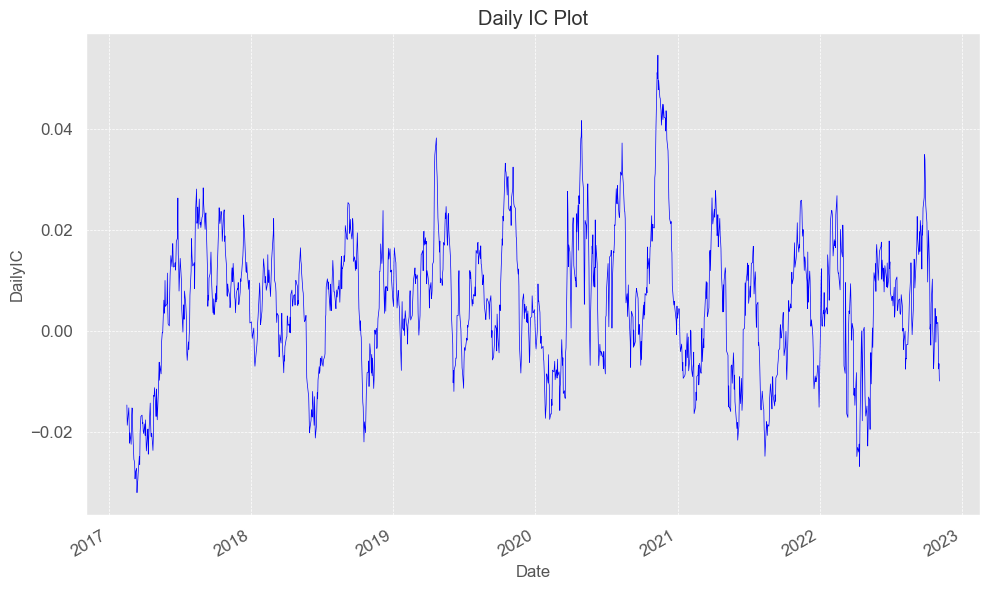

In [911]:
merged = price(best_model_params, dir_path)

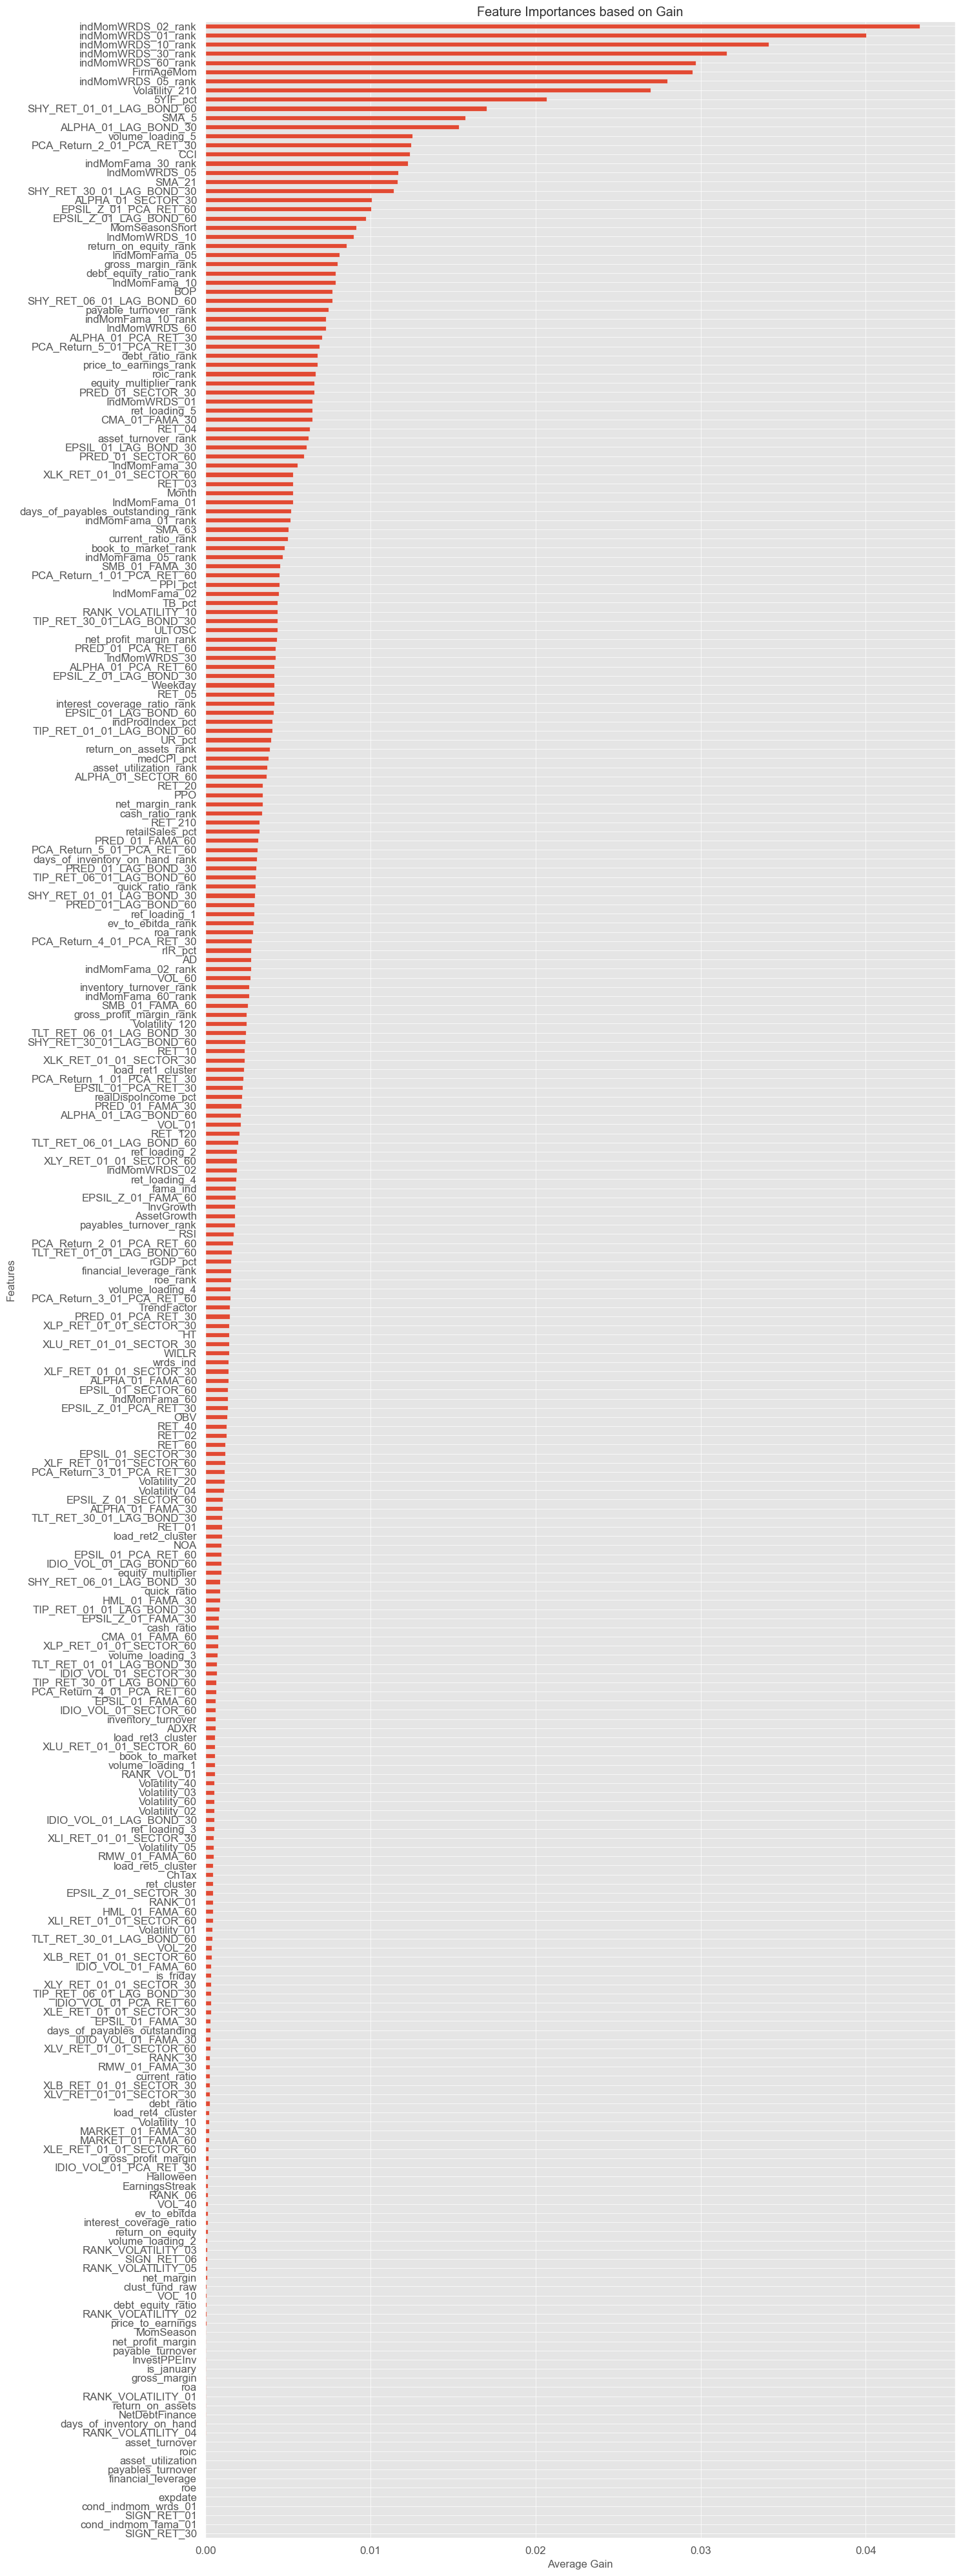

In [912]:
gain(best_model_params['gain'])

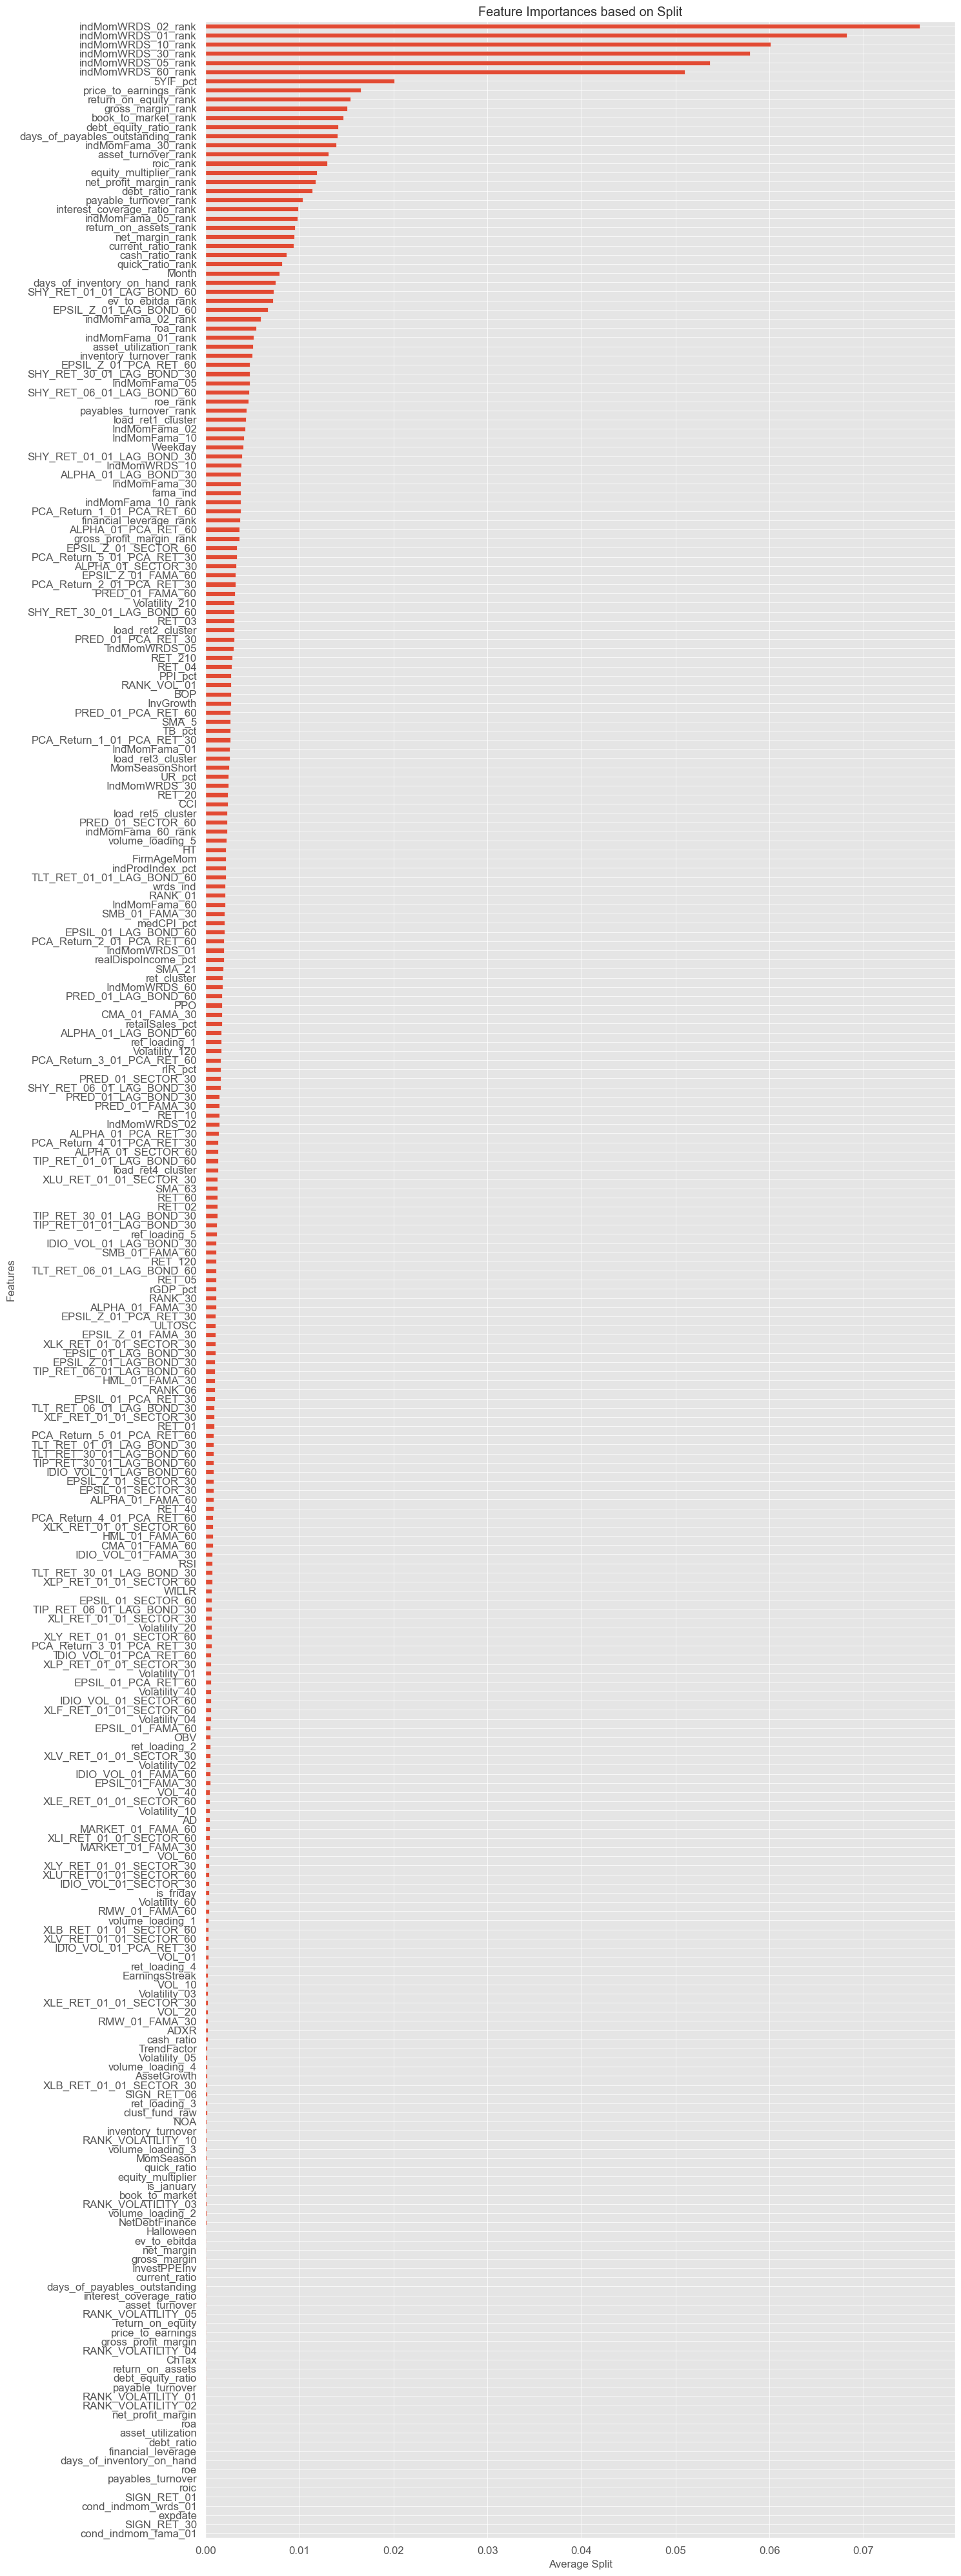

In [913]:
split(best_model_params['split'])

# Convert to ticker

In [914]:
ticker = pd.read_parquet(get_load_data_parquet_dir() / 'data_ticker.parquet.brotli')

In [915]:
tic = merged.merge(ticker, left_index=True, right_index=True, how='left')

In [916]:
tic = tic.reset_index().set_index(['window', 'ticker', 'date'])

In [917]:
tic = tic.drop('permno', axis=1)

# Backtest

In [918]:
%%time
#Perform backtest
pred_return = backtest(tic, num_stocks=100)

----------------------------------------------
2017
Num of tickers: 439
----------------------------------------------
2017
Num of tickers: 437
----------------------------------------------
2017
Num of tickers: 437
----------------------------------------------
2017
Num of tickers: 437
----------------------------------------------
2017
Num of tickers: 436
----------------------------------------------
2017
Num of tickers: 436
----------------------------------------------
2017
Num of tickers: 436
----------------------------------------------
2017
Num of tickers: 432
----------------------------------------------
2017
Num of tickers: 432
----------------------------------------------
2017
Num of tickers: 432
----------------------------------------------
2017
Num of tickers: 432
----------------------------------------------
2017
Num of tickers: 432
----------------------------------------------
2018
Num of tickers: 450
----------------------------------------------
2018
Num of ticke

# Calculate Total Returns

## Long

In [919]:
#Get SPY returns (matching timeframe as our backtest)
spy_return = get_spy(start_date=pred_return.index[0]-timedelta(days=1), end_date=pred_return.index[-1]+timedelta(days=1))
spy = spy_return['spyRet']

[*********************100%%**********************]  1 of 1 completed


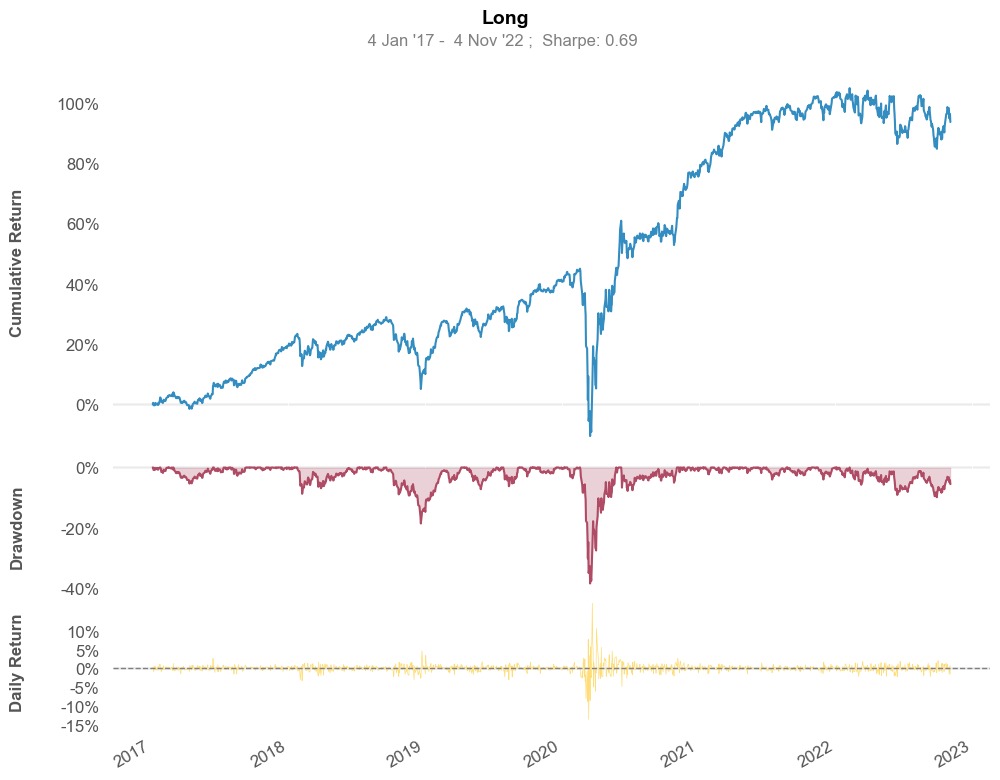

In [920]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='long')
long = pred_return_opt['totalRet']
# qs.reports.metrics(mode='basic', returns=stock, benchmark=spy, title='Long', fig_size=(10, 10))
qs.plots.snapshot(mode='basic', returns=long, benchmark=spy, title='Long', fig_size=(10, 10))

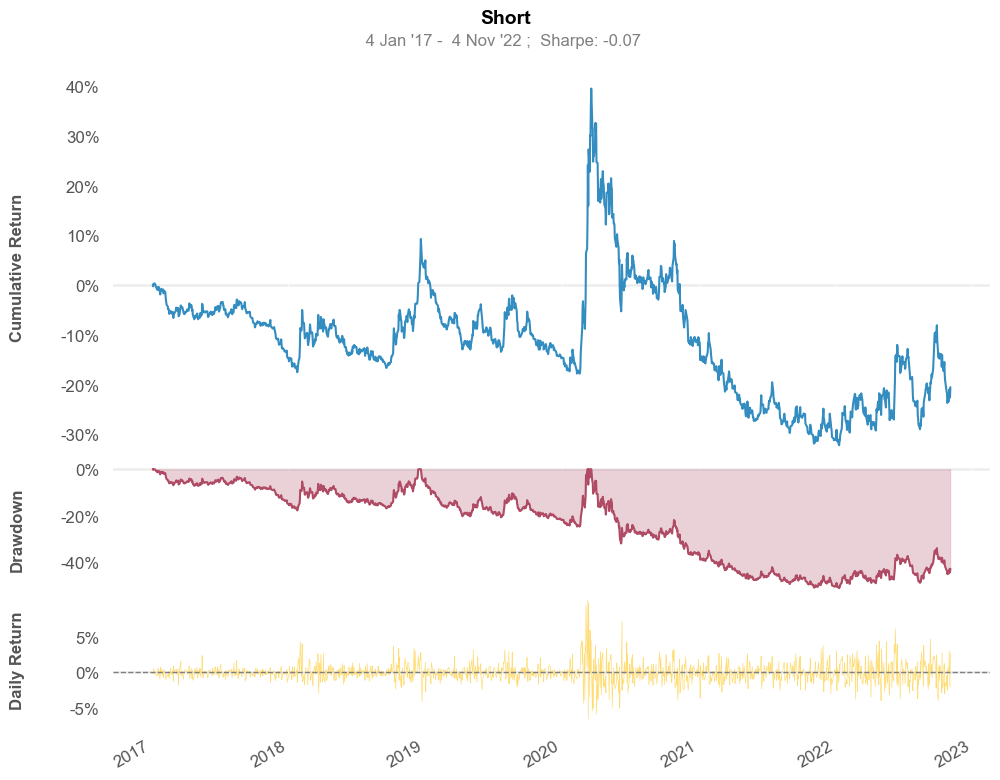

In [921]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='short')
short = pred_return_opt['totalRet']
# qs.reports.metrics(mode='basic', returns=stock, benchmark=spy, title='Short', fig_size=(10, 10))
qs.plots.snapshot(mode='basic', returns=short, benchmark=spy, title='Short', fig_size=(10, 10))

In [922]:
long.corr(short)

-0.9158266997153519

## Both

In [923]:
data = pred_return.copy(deep=True)
pred_return_opt = port_opt(data=data, window_size=21, port_opt_func=ewp, option='both')
stock = pred_return_opt['totalRet']
qs.reports.html(stock, 'SPY', output=dir_path / 'report.html')

[*********************100%%**********************]  1 of 1 completed
